# Dimensionality reduction using Gordon's theorem

The Johnson-Lindenstrauss lemma guarantees that with high probability a random projection $\Phi$ will preserve the inter-point distances and angles in a data set $X\subset \mathbb{R}^d$ (of $n$ samples) up to a distortion parameter $\varepsilon$ in the sense that

$$
  (1 - \varepsilon) \| x - y \|^2 < \| \Phi(x) - \Phi(y) \|^2 < (1 + \varepsilon) \| x - y \|^2, \quad \forall x,y\in X
$$

as long as target dimension $m$ satisfies

$$
  m \geq \frac{4\log n}{\varepsilon^2 / 2 - \varepsilon^3 / 3} .
$$

Note that this lower bound is a worst case scenario estimate as it doesn't depend on $X$. This has been implemented in skicit-learn module `random_projection.py` as function `johnson_lindenstrauss_min_dim`.
    
Gordon's theorem [1] improves the lower bound on target dimension by taking into account the geometric complexity of $X$. More precisely, there is a universal constant $c > 0$ for which the lower bound

$$
  m \geq c \, \frac{g(T)^2 + 1}{\varepsilon^2}
$$

guarantees that, on average, the distortion doesn't exceed $\varepsilon$ in the sense that

$$
  \mathbb{E} \max_{x \in T} \big| \, \| \Phi(x) \|^2 - 1 \, \big| < \varepsilon .
$$

Here the geometric complexity of $X$ is measured by

$$
  g(T) = \mathbb{E} \max_{x \in T} \big| \, \langle \gamma , x \rangle \, \big| ,
$$

where $T$ is the set of normalized difference vectors of $X$ and $\gamma$ is a standard $d$-dimensional normal variable.

This presentation follows [2], which contains numerous ideas for further improvements.

References:

[1] Y. Gordon: On Milman's inequality and random subspaces which escape through a mesh in R^n.
    _Geometric Aspects of Functional Analysis_, 84--106, 1988.

[2] J. Bourgain, S. Dirksen, J. Nelson: Toward a unified theory of sparse dimensionality reduction in Euclidean space.
    _Geometric and Functional Analysis_, 25(4): 1009--1088, 2015.

In [1]:
import numpy as np

# Define a function to compute the set T of normalized difference vectors
def diffvect(X):
    """
    Input: Data matrix X as a numpy array of shape [n_samples, n_features]
    Returns: Numpy array T of normalized difference vectors with shape [n_diffs, n_features], where
    n_diffs = n_samples * (n_samples - 1) / 2
    """
    n_samples, n_features = X.shape
    meps = np.finfo(float).eps
    T = np.array([(X[i] - X[j]) / max(np.linalg.norm(X[i]-X[j]), meps)
         for i in range(n_samples) for j in range(i)])
    return T

In [2]:
# Define a function to compute the geometric complexity of the dataset X
def geom_complexity(X):
    """
    Input: Data matrix X as a numpy array of shape [n_samples, n_features]
    Returns: Geometric complexity of X
    """
    n_samples, n_features = X.shape
    T = diffvect(X)
    N = 1000  # number of samples from the normal distribution, increase for more reliability
    G = np.random.randn(N, n_features)
    # G.shape = (N, n_features)
    # T.shape = (n_diffs, n_features)
    # np.dot(G,T.T).shape = (N, n_diffs)
    # np.amax(np.abs(_), axis=1).shape = (N,)
    g_T = np.mean(np.amax(np.abs(np.dot(G,T.T)), axis=1))
    return g_T

In [3]:
def gordon_min_dim(g_T, eps=0.1):
    """
    Inputs:
      g_T: A numerical value describing the geometric complexity of the dataset
      eps: Allowed amount of distortion on average (default is 0.1)
    Returns: A suggestion for the target dimension m
    """
    c = 0.7  # experimentally adjusted
    m = c * ((g_T**2 + 1)/eps**2).astype(np.int)
    return m

In [4]:
from sklearn import random_projection

# Define a function to measure the distortion induced on the dataset by a random projection
def test(X, m):
    """Measure the distortion on X from random projection with target dimension m.
    Note that Gordon's theorem states that the expectation of the distortion doesn't
    exceed eps, whereas here we consider individual random projections.
    """
    n_samples, n_features = X.shape
    Phi = random_projection.gaussian_random_matrix(m, n_features)
    T = diffvect(X)
    # T.shape = (n_diffs, n_features)
    # Phi.shape = (m, n_features)
    # np.dot(T, Phi.T).shape = (n_diffs, m)
    # np.linalg.norm(_, axis=1).shape = (n_diffs,)
    norms = np.linalg.norm(np.dot(T, Phi.T), axis=1)
    # np.abs(norms - 1).shape = (n_diffs,)
    return np.max(np.abs(norms - 1))

We will then compare Johnson-Lindenstrauss lemma with Gordon's theorem in dimensionality reduction of two datasets of $n$ samples, namely the Olivetti faces dataset and a random dataset of the same size.

In [5]:
from sklearn.datasets import fetch_olivetti_faces

n = 150  # number of samples (max 400)
eps = 0.1  # allowed amount of distortion
dataset = fetch_olivetti_faces()
X_faces = dataset.data[:n,:]

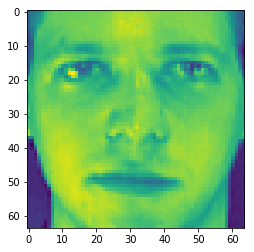

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

# a sample data point from the Olivetti faces dataset
plt.imshow(X_faces[0].reshape(64,64))

In [7]:
print("{} samples of 4096-dimensional face image data.".format(n))

g_T_faces = geom_complexity(X_faces)
m_JL_n = random_projection.johnson_lindenstrauss_min_dim(n, eps=eps)
m_G_faces = gordon_min_dim(g_T_faces, eps=eps)

print()
print("Johnson-Lindenstrauss lemma")
print("Target dimension: {:.0f}".format(m_JL_n))
if m_JL_n < 4096:
    d_JL_faces = test(X_faces, int(m_JL_n))
    comparison = " < " if d_JL_faces < eps else " > "
    print("Distortion for sample projection: {:.3f}".format(d_JL_faces) + comparison + str(eps))
else:
    print("Target dimension too large.")

print()
print("Gordon's theorem")
print("Geometric complexity of face image data: {:.3f}".format(g_T_faces))
print("Target dimension: {:.0f}".format(m_G_faces))
if m_G_faces < 4096:
    d_G_faces = test(X_faces, int(m_G_faces))
    comparison = " < " if d_G_faces < eps else " > "
    print("Distortion for sample projection: {:.3f}".format(d_G_faces) + comparison + str(eps))
else:
    print("Target dimension too large.")

150 samples of 4096-dimensional face image data.

Johnson-Lindenstrauss lemma
Target dimension: 4294
Target dimension too large.

Gordon's theorem
Geometric complexity of face image data: 3.465
Target dimension: 910
Distortion for sample projection: 0.094 < 0.1


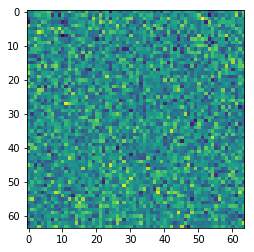

In [8]:
d = 4096

# Randomly generate a dataset
X_random = np.random.randn(n,d)

# a sample from the random dataset
plt.imshow(X_random[0].reshape(64,64))

In [9]:
print("{} random samples from {}-dimensional normal distribution.".format(n,d))

g_T_random = geom_complexity(X_random)
m_G_random = gordon_min_dim(g_T_random, eps=eps)

print()
print("Johnson-Lindenstrauss lemma")
print("Target dimension: {:.0f}".format(m_JL_n))
if m_JL_n < d:
    d_JL_random = test(X_random, int(m_JL_n))
    comparison = " < " if d_JL_random < eps else " > "
    print("Distortion for sample projection: {:.3f}".format(d_JL_random) + comparison + str(eps))
else:
    print("Target dimension too large.")

print()
print("Gordon's theorem")
print("Geometric complexity of randomly generated dataset: {:.3f}".format(g_T_random))
print("Target dimension: {:.0f}".format(m_G_random))
if m_G_random < d:
    d_G_random = test(X_random, int(m_G_random))
    comparison = " < " if d_G_random < eps else " > "
    print("Distortion for sample projection: {:.3f}".format(d_G_random) + comparison + str(eps))
else:
    print("Target dimension too large.")

150 random samples from 4096-dimensional normal distribution.

Johnson-Lindenstrauss lemma
Target dimension: 4294
Target dimension too large.

Gordon's theorem
Geometric complexity of randomly generated dataset: 3.740
Target dimension: 1049
Distortion for sample projection: 0.087 < 0.1


In [10]:
if m_G_faces < m_G_random:
    print("Target dimension {:.0f} for faces is smaller than the target dimension {:.0f} for random data. ".format(m_G_faces, m_G_random))
    print("The geometric complexity of the face data ({:.3f}) is smaller than that of randomly generated data ({:.3f}).".format(g_T_faces, g_T_random))
else:
    print("Surprisingly, the target dimension {:.0f} for faces is greater than the target dimension {:.0f} for random data.".format(m_G_faces, m_G_random))
    print("The geometric complexity of the face data ({:.3f}) is greater than that of randomly generated data. ({:.3f})".format(g_T_faces, g_T_random))

Target dimension 910 for faces is smaller than the target dimension 1049 for random data. 
The geometric complexity of the face data (3.465) is smaller than that of randomly generated data (3.740).
